In [10]:
import pandas as pd
import numpy as np
from dateutil.parser import parse 
import matplotlib as mpl
from matplotlib.pyplot import MultipleLocator
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm 
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from datetime import datetime
import time
from scipy.interpolate import interp1d
import statsmodels.api as sm
import itertools
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
# 设置中文和负号正常显示
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

### 导入数据

In [11]:
df = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)
df

,日期,DATA_DT,内存负载,主机CPU平均负载
0,2020-03-01 01:00:00,1582995600,81.8242,2.8333
1,2020-03-01 02:00:00,1582999200,81.8145,3.1818
2,2020-03-01 03:00:00,1583002800,81.8092,3.0833
3,2020-03-01 04:00:00,1583006400,81.8042,3.0833
4,2020-03-01 05:00:00,1583010000,81.8333,2.5000
...,...,...,...,...
2202,2020-05-31 19:00:00,1590922800,70.6183,2.0000
2203,2020-05-31 20:00:00,1590926400,70.5208,1.9167
2204,2020-05-31 21:00:00,1590930000,70.5608,1.7500
2205,2020-05-31 22:00:00,1590933600,70.5292,2.0000


In [12]:
df["内存负载"].isnull().any()

True

In [13]:
df.loc[2039]

日期           2020-05-25 00:00:00
DATA_DT               1590336000
内存负载                     70.2192
主机CPU平均负载                 2.6667
Name: 2039, dtype: object

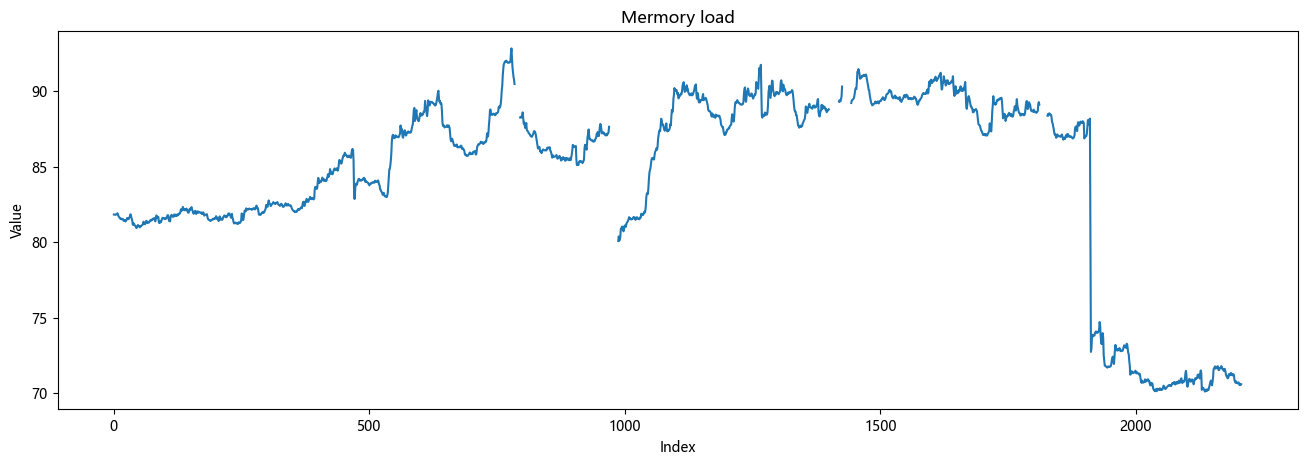

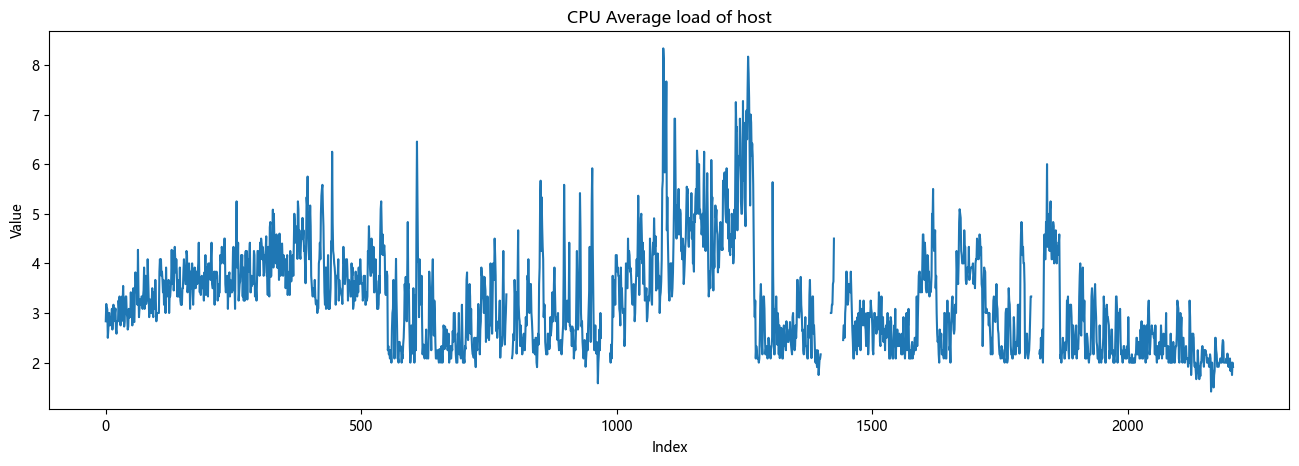

In [14]:
# Draw Plot-----绘图函数
def plot_df(df, x, y, title="", xlabel='Index', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(df, x=df.index, y= df["内存负载"], title='Mermory load')
plot_df(df, x=df.index, y= df["主机CPU平均负载"], title='CPU Average load of host')

### 缺失值填充

In [6]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out
# 使用k-近邻法填补缺失值
df["内存负载"] = knn_mean(df["内存负载"], 24)
df["主机CPU平均负载"] = knn_mean(df["主机CPU平均负载"], 24)

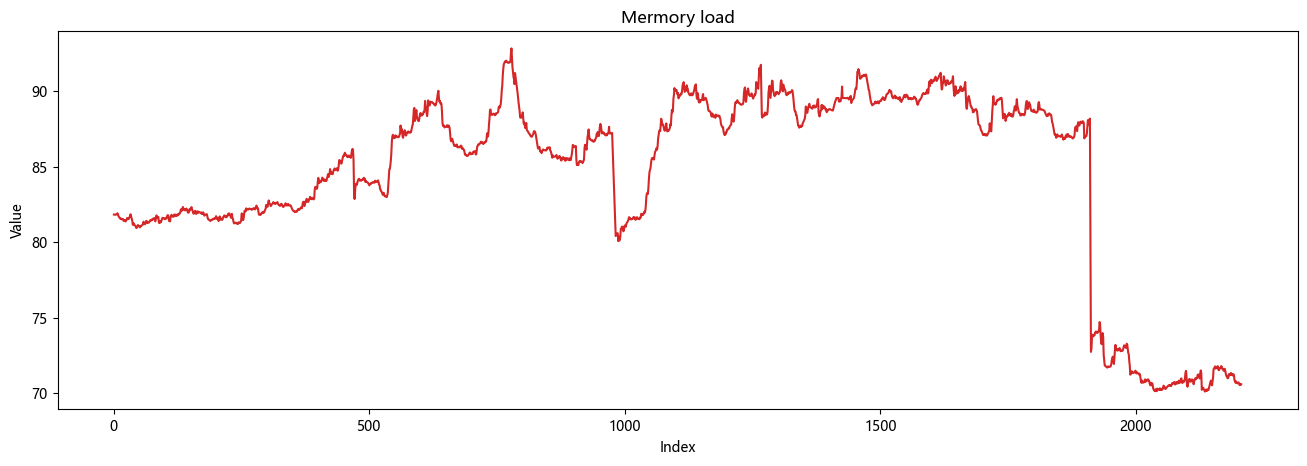

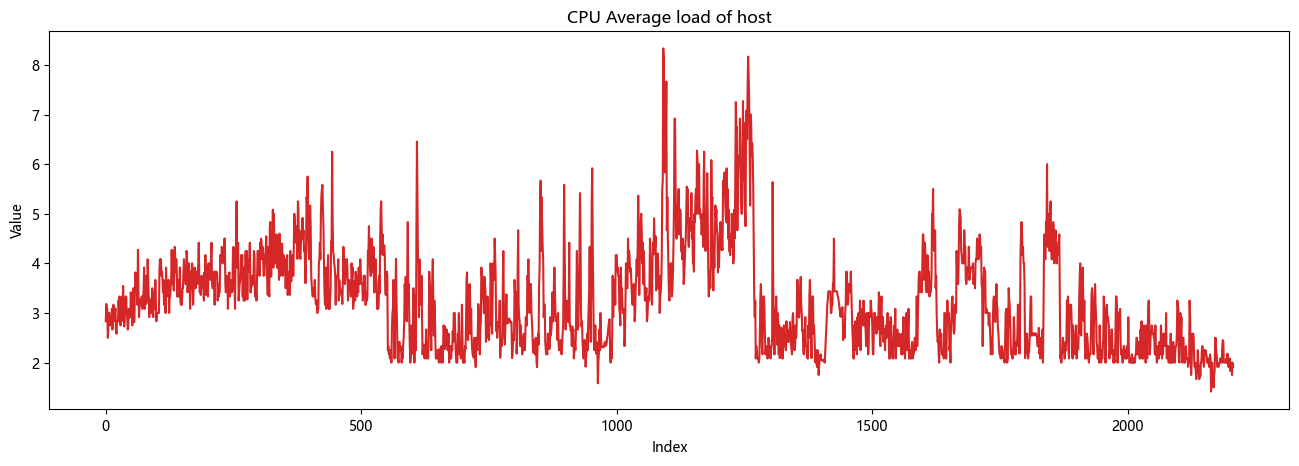

In [7]:
plot_df(df, x=df.index, y= df["内存负载"], title='Mermory load')
plot_df(df, x=df.index, y= df["主机CPU平均负载"], title='CPU Average load of host')

In [8]:
# define function for ADFtest
def adf_test(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test：')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critica1 Value（%s）'%key] = value
    print(dfoutput)

In [9]:
# dif = []
# dif = df["主机CPU平均负载"].diff(1)
# timeSeries = dif[1:]
adf_test(df["主机CPU平均负载"])

Results of Dickey-Fuller Test：
Test Statistic                   -3.984235
p-value                           0.001495
#Lags Used                       26.000000
Number of Observations Used    2180.000000
Critica1 Value（1%）               -3.433353
Critica1 Value（5%）               -2.862867
Critica1 Value（10%）              -2.567476
dtype: float64


In [10]:
timeSeries = df["内存负载"]
dataframe = pd.DataFrame()
num_hour = 336

In [11]:
for i in range(num_hour,0,-1):
    dataframe['t-'+str(i)] = timeSeries.shift(i)
dataframe['t'] = timeSeries.values
dataframe

,t-336,t-335,t-334,t-333,t-332,t-331,t-330,t-329,t-328,t-327,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.8242
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.8242,81.8145
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.8242,81.8145,81.8092
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,81.8242,81.8145,81.8092,81.8042
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,81.8242,81.8145,81.8092,81.8042,81.8333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,87.1542,87.1600,87.0617,86.9792,87.0025,86.9850,87.0142,86.9883,86.9767,86.9250,...,70.8275,70.7792,70.6782,70.7692,70.6775,70.6733,70.6350,70.6733,70.7008,70.6183
2203,87.1600,87.0617,86.9792,87.0025,86.9850,87.0142,86.9883,86.9767,86.9250,86.8683,...,70.7792,70.6782,70.7692,70.6775,70.6733,70.6350,70.6733,70.7008,70.6183,70.5208
2204,87.0617,86.9792,87.0025,86.9850,87.0142,86.9883,86.9767,86.9250,86.8683,86.8733,...,70.6782,70.7692,70.6775,70.6733,70.6350,70.6733,70.7008,70.6183,70.5208,70.5608
2205,86.9792,87.0025,86.9850,87.0142,86.9883,86.9767,86.9250,86.8683,86.8733,86.9092,...,70.7692,70.6775,70.6733,70.6350,70.6733,70.7008,70.6183,70.5208,70.5608,70.5292


In [12]:
pd.set_option('display.max_columns', 10)
dataframe = dataframe[num_hour+1:]
df_4 = dataframe.corr()
df_4

,t-336,t-335,t-334,t-333,t-332,...,t-4,t-3,t-2,t-1,t
t-336,1.000000,0.997991,0.994601,0.991006,0.987501,...,-0.137951,-0.139425,-0.140817,-0.142294,-0.143922
t-335,0.997991,1.000000,0.997989,0.994595,0.990996,...,-0.136848,-0.138352,-0.139820,-0.141204,-0.142666
t-334,0.994601,0.997989,1.000000,0.997986,0.994589,...,-0.135791,-0.137261,-0.138759,-0.140219,-0.141589
t-333,0.991006,0.994595,0.997986,1.000000,0.997984,...,-0.134817,-0.136195,-0.137659,-0.139150,-0.140594
t-332,0.987501,0.990996,0.994589,0.997984,1.000000,...,-0.133889,-0.135214,-0.136586,-0.138043,-0.139518
...,...,...,...,...,...,...,...,...,...,...,...
t-4,-0.137951,-0.136848,-0.135791,-0.134817,-0.133889,...,1.000000,0.998621,0.996119,0.993721,0.991451
t-3,-0.139425,-0.138352,-0.137261,-0.136195,-0.135214,...,0.998621,1.000000,0.998624,0.996130,0.993738
t-2,-0.140817,-0.139820,-0.138759,-0.137659,-0.136586,...,0.996119,0.998624,1.000000,0.998628,0.996140
t-1,-0.142294,-0.141204,-0.140219,-0.139150,-0.138043,...,0.993721,0.996130,0.998628,1.000000,0.998632


In [13]:
X = df_4.index[0:-1]
X_index = [336-i for i in range(len(X))]
temp = df_4.loc[:,"t"].values
Y = temp[0:-1]
Y_temp = list(Y)

In [14]:
X_index.reverse()
Y_temp.reverse()

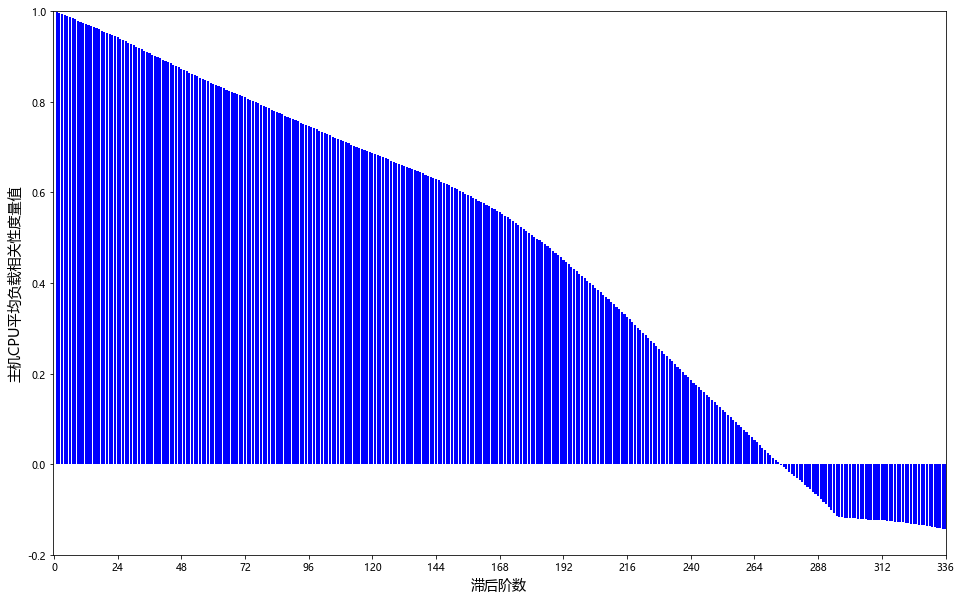

In [15]:
plt.figure(figsize=(16, 10))
plt.xlabel(u"滞后阶数", fontsize=14)
plt.ylabel(u"主机CPU平均负载相关性度量值", fontsize=14)
plt.xticks(X_index)
plt.bar(x=X_index, height=Y_temp,color='blue')
x_major_locator=MultipleLocator(24)
# y_major_locator=MultipleLocator(24)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)
plt.xlim(-.5,336)
plt.ylim(-.2,1)
plt.show()

In [16]:
# plt.gca().set(title="", xlabel="滞后阶数", ylabel="相关性度量值")
# plt.bar(X_index, Y,color='blue')
# plt.xlim(-.5, 336)
# plt.xticks(())
# plt.ylim(-0.5, 1)
# plt.yticks(())
# plt.show()

### 去除季节性因素

In [17]:
temp_Series =df["内存负载"]

Text(0.5, 0.98, 'Additive Decompose')

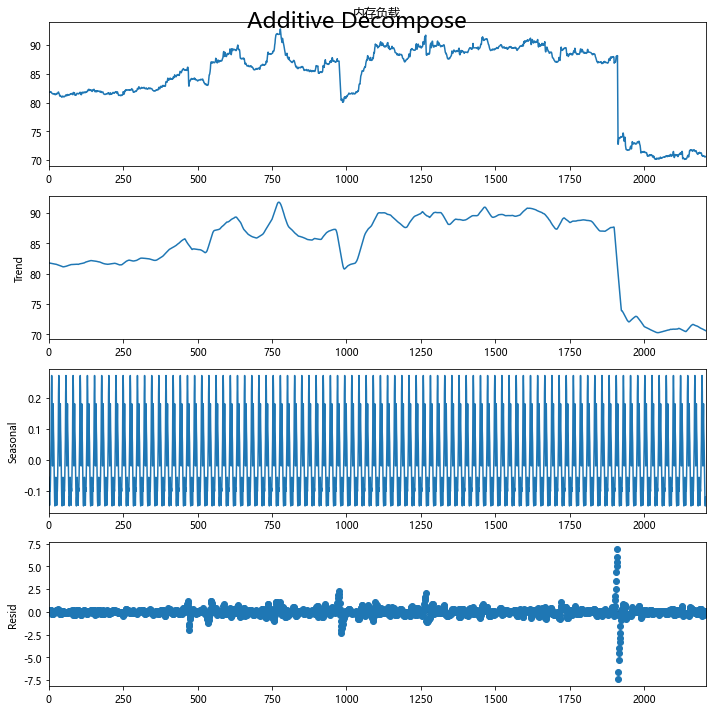

In [18]:
plt.rcParams.update({'figure.figsize': (10,10)})
result_add = sm.tsa.seasonal_decompose(temp_Series, model='additive',period = 24, extrapolate_trend='freq')
result_add.plot().suptitle('Additive Decompose', fontsize=22)

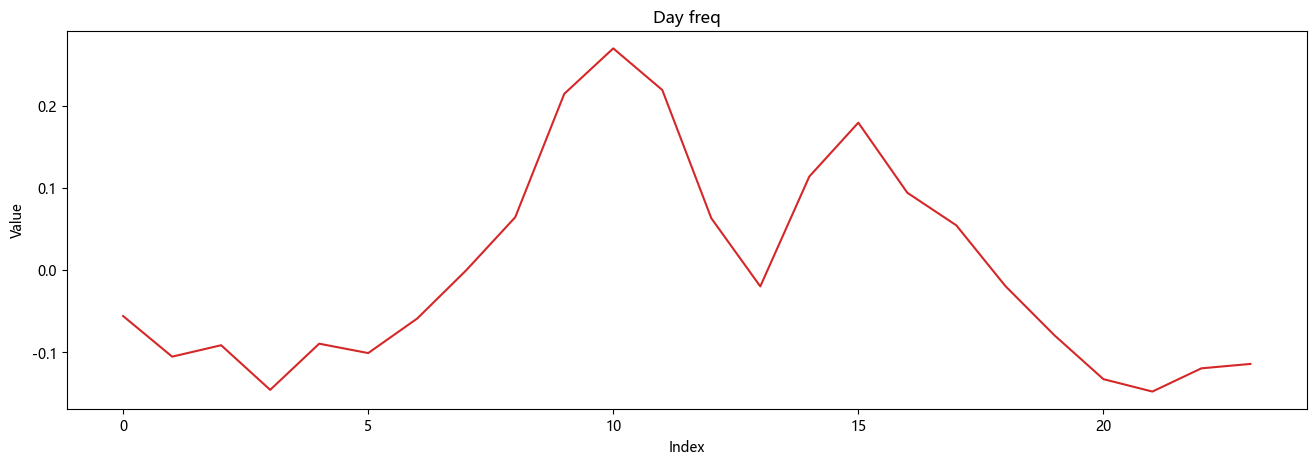

In [19]:
# 周期值24
a = result_add.seasonal
season = []
for i in range(24):
    season.append(a[i])
plot_df(season, x=range(24), y= season, title='Day freq')
# season[-1]

In [20]:
arr = temp_Series - result_add.seasonal
arr

0       81.879860
1       81.919616
2       81.900399
3       81.949771
4       81.922626
          ...    
2202    70.637365
2203    70.599807
2204    70.693303
2205    70.676840
2206    70.699328
Length: 2207, dtype: float64

In [21]:
train = arr[0:2046]
test = arr[2046:]
train[1:2040]

1       81.919616
2       81.900399
3       81.949771
4       81.922626
5       81.935757
          ...    
2035    70.297307
2036    70.289203
2037    70.355140
2038    70.239328
2039    70.333183
Length: 2039, dtype: float64

### 9.预测

In [22]:
model = sm.tsa.ARIMA(train, order=(0, 1, 2))
result = model.fit()

In [23]:
te = result.predict(start=1,end=2039, dynamic=False, typ='levels')
len(te.values)

2039

In [24]:
# len(arr_te)
# arr_te[1848:1872]

In [25]:
# result_add.seasonal[0:24]

In [26]:
# 预测值填补上周期值
# for i in range(int(len(te)/24)):
#     arr_te[i*24:i*24+24] += result_add.seasonal[0:24].values

In [27]:
# temp = pd.Series(arr_te,index=te.index)
# temp

In [28]:
# plot_df(te, x=te.index, y= te.values, title='predict')

In [29]:
# plot_df(temp, x=temp.index, y= temp.values, title='predict+freq')

In [30]:
# te = result.predict(start=1,end=2039, dynamic=False, typ='levels')
# plt.figure(figsize=(20,8),dpi=80)
# num = 1780
# train_temp = df["内存负载"][1+num:1+num+24]
# te_temp1 = te[num:num+24]
# te_temp2 = temp[num:num+24]
# # color可以百度颜色代码
# plt.plot(train_temp.index,train_temp,label="truth",color="black")
# plt.plot(te_temp1.index,te_temp1,label="predict",color="red",linestyle="--")
# plt.plot(te_temp2.index,te_temp2,label="predict+freq",color="blue",linestyle="--")

# #绘制网格
# plt.grid(alpha=0.4,linestyle=':')

# #展示
# plt.show()

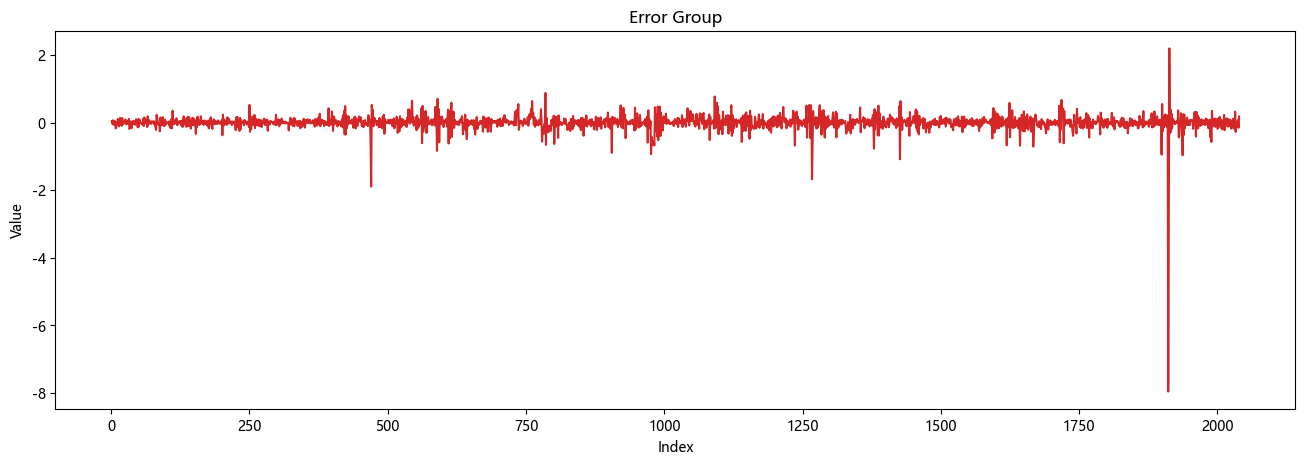

In [31]:
arr1 = train[1:2040] - te.values
error = pd.Series(arr1,index=te.index)
plot_df(error, x=error.index, y= error.values, title='Error Group')

### 平滑噪声数据

In [32]:
from scipy.interpolate import UnivariateSpline
from numpy import linspace,exp
from numpy.random import randn
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess

In [33]:
error

1       0.045389
2      -0.033084
3       0.071377
4      -0.059297
5       0.049489
          ...   
2035    0.005526
2036   -0.005833
2037    0.074634
2038   -0.150794
2039    0.180173
Length: 2039, dtype: float64

In [34]:
# Loess Smoothing (5% and 15%)
# df_loess_5 = pd.DataFrame(lowess(error, np.arange(len(error)), frac=0.008)[:, 1], index=error.index, columns=['内存负载'])
# # df_loess_15 = pd.DataFrame(lowess(df_orig.value, np.arange(len(df_orig.value)), frac=0.15)[:, 1], index=df_orig.index, columns=['value'])
# plt.plot(error,color = 'black')
# plt.plot(df_loess_5,label = '拟合曲线',color = 'red')

### 箱线图

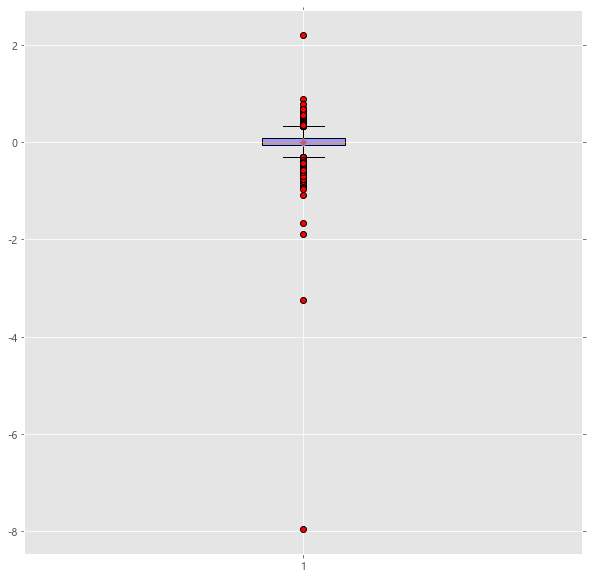

In [35]:
# 设置图形的显示风格
plt.style.use('ggplot')
# 绘图：daily_Ionset_r_c1_predicted的箱线图

data = error

plt.boxplot(x = data, # 指定绘图数据
 
            patch_artist=True, # 要求用自定义颜色填充盒形图，默认白色填充
 
            showmeans=True, # 以点的形式显示均值
 
            boxprops = {'color':'black','facecolor':'#9999ff'}, # 设置箱体属性，填充色和边框色
 
            flierprops = {'marker':'o','markerfacecolor':'red','color':'black'}, # 设置异常值属性，点的形状、填充色和边框色
 
            meanprops = {'marker':'D','markerfacecolor':'indianred'}, # 设置均值点的属性，点的形状、填充色
 
            medianprops = {'linestyle':'--','color':'orange'}) # 设置中位数线的属性，线的类型和颜色
 
# 设置y轴的范围
#plt.ylim(0,3000)

# 去除箱线图的上边框与右边框的刻度标签
plt.tick_params(top='off', right='off')
# 保存图像
plt.savefig('./results_imgs.png', bbox_inches='tight') #保存的文件名，裁剪掉图表多余的空白区域
# 显示图形
plt.show()

In [36]:
error_temp = pd.DataFrame(error)
des = error_temp.describe()
U = des.iloc[6]
L = des.iloc[4]
IQR = U-L
top = U+1.5*IQR
bottom = L-1.5*IQR
des

,0
count,2039.000000
mean,0.000014
std,0.270406
min,-7.956998
25%,-0.069766
50%,0.007307
75%,0.088974
max,2.198722


In [37]:
for i in range(len(error)):
    if (error.iloc[i] > top).bool():
        error.iloc[i] = np.nan
    if (error.iloc[i] < bottom).bool():
        error.iloc[i] = np.nan

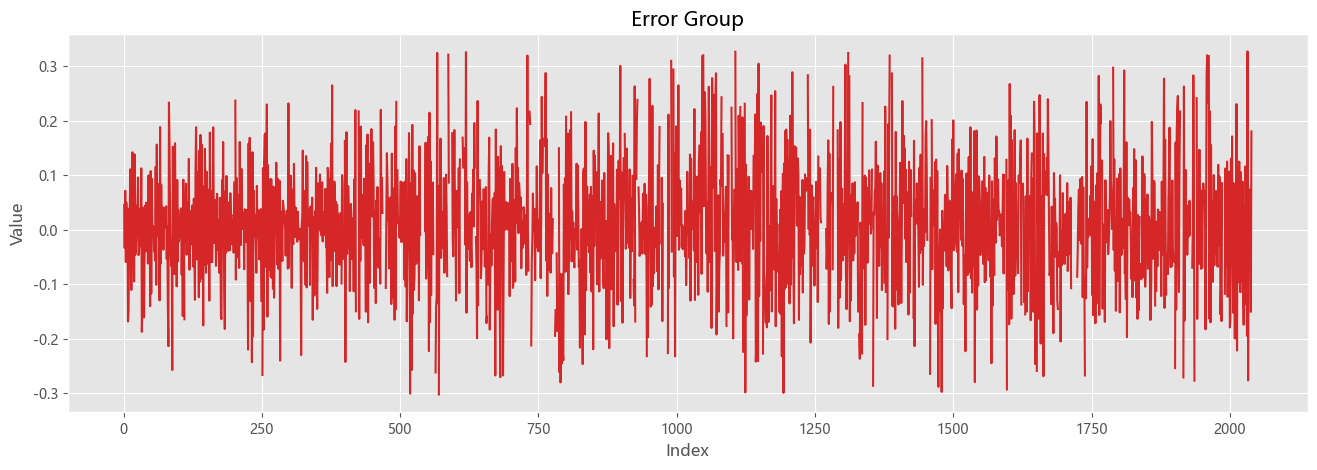

In [38]:
plot_df(error, x=error.index, y= error.values, title='Error Group')

In [39]:
error_temp2 = pd.DataFrame(error)
print(f"缺失率为:{(100-(error_temp2.count()/(len(error))*100)).item()}%")

缺失率为:8.092202059833255%


In [40]:
error_temp2.columns = ["value"]
error_temp2

,value
1,0.045389
2,-0.033084
3,0.071377
4,-0.059297
5,0.049489
...,...
2035,0.005526
2036,-0.005833
2037,0.074634
2038,-0.150794


In [41]:
error_temp2["value"] = knn_mean(error_temp2["value"], 9)

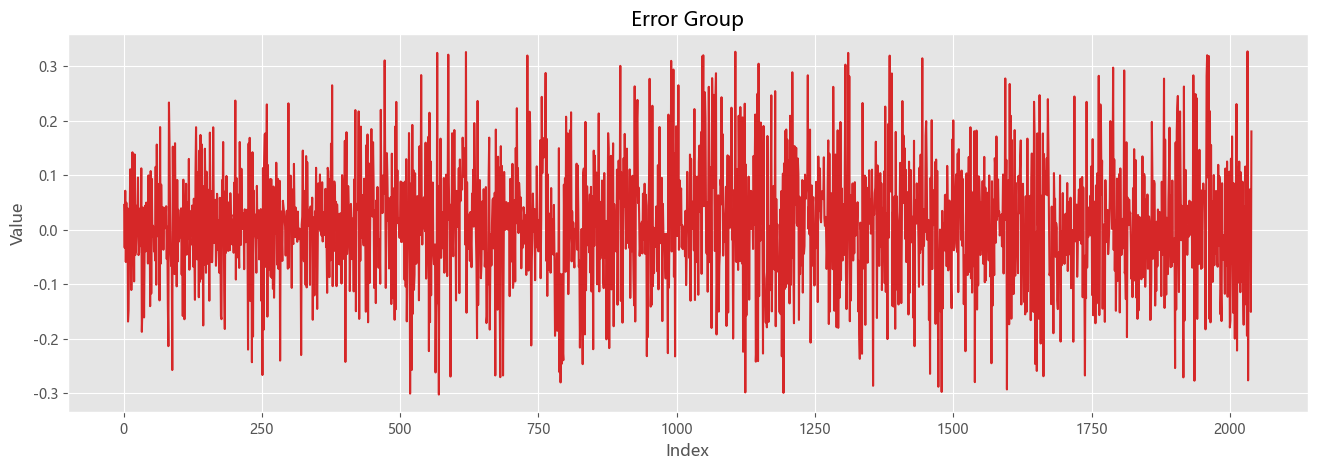

In [42]:
plot_df(error_temp2["value"], x=error_temp2["value"].index, y= error_temp2["value"].values, title='Error Group')

In [43]:
# Loess Smoothing (5% and 15%)
# df_loess_5 = pd.DataFrame(lowess(error_temp2["value"], np.arange(len(error_temp2["value"])), frac=0.008)[:, 1], index=error.index, columns=['value'])
# # df_loess_15 = pd.DataFrame(lowess(df_orig.value, np.arange(len(df_orig.value)), frac=0.15)[:, 1], index=df_orig.index, columns=['value'])
# plt.plot(error,color = 'black')
# plt.plot(df_loess_5,label = '拟合曲线',color = 'red')

In [44]:
# df_loess_5["value"]

### 生成数据集

In [45]:
# 索引185指18点
truth = error_temp2["value"].loc[168:2040]

In [46]:
# 每天的7点到18点的内存负载数据
# label矩阵 从第8天算共78天的误差数据,索引168:2039
label = [] 
for i in range(78):
    arr = truth.loc[174+i*24:185+i*24].values
    label.append(arr)
# len(label) # 维度 78*12

In [47]:
# data_train = error.loc[1:2040]
# data_train.loc[162:173]

In [48]:
# # 7点前面的12个ARIMA误差值
# train1 = []
# for i in range(78):
#     arr = data_train.loc[174-12+i*24:185-12+i*24].values
#     train1.append(arr)
# # len(train1) # 维度 78*12
# # train1

In [49]:
# type-1
# 前3天同一时刻的误差波动值
train2 = []
for i in range(78):
    arr1 = error.loc[174-24*3+i*24:185-24*3+i*24].values
    arr2 = error.loc[174-24*2+i*24:185-24*2+i*24].values
    arr3 = error.loc[174-24*1+i*24:185-24*1+i*24].values
    temp = np.append(arr1,arr2)
    train2.append(np.append(temp,arr3))
# train2 # 维度 78*36

In [50]:
# # type-2
# # 前7天同一时刻的误差波动值
# train2 = []
# for i in range(78):
#     arr1 = error.loc[174-24*7+i*24:185-24*7+i*24].values
#     arr2 = error.loc[174-24*6+i*24:185-24*6+i*24].values
#     arr3 = error.loc[174-24*5+i*24:185-24*5+i*24].values
#     arr4 = error.loc[174-24*4+i*24:185-24*4+i*24].values
#     arr5 = error.loc[174-24*3+i*24:185-24*3+i*24].values
#     arr6 = error.loc[174-24*2+i*24:185-24*2+i*24].values
#     arr7 = error.loc[174-24*1+i*24:185-24*1+i*24].values
#     temp = np.append(arr1,arr2)
#     temp = np.append(temp,arr3)
#     temp = np.append(temp,arr4)
#     temp = np.append(temp,arr5)
#     temp = np.append(temp,arr6)
#     temp = np.append(temp,arr7)
#     train2.append(temp)
# # train2 # 维度 78*84
# # train2[0]

In [51]:
# # 24个趋势值(后面减前面)
# train3 = []
# dif = df["内存负载"].diff(1)
# for i in range(71):
#     arr = dif[120:2040].loc[126+i*24:149+i*24].values
#     train3.append(arr)
# # train3 # 维度 71*24

In [52]:
# train_end = []
# for i in range(78):
#     train_end.append(np.append(train1[i],train2[i]))
# train_end

### 神经网络训练误差数据

In [53]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [54]:
train_end = np.array(train2)
train_end[-1:].shape

(1, 36)

In [55]:
train_X = torch.Tensor(train_end.reshape(-1, 3, 12))
train_Y = torch.Tensor(np.array(label).reshape(-1, 1, 12))
train_Y.shape

torch.Size([78, 1, 12])

In [56]:
test_X = torch.Tensor(train_end[-1:].reshape(-1, 3, 12))

In [57]:
class lstm(nn.Module):
    def __init__(self,input_size=16,hidden_size=100,output_size=1,num_layer=2):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer,batch_first=True)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        # x ->[78,3,12]
        x,_ = self.layer1(x)
        # [78,3,12] -> [78,3,128]
        x = x[:,[2],:]
        b, s, h = x.size()
        # [78,1,128] -> [78,120]
        x = x.view(-1,h)
        # [78,120] -> [78,12]
        x = self.layer2(x)
        # [78,1] -> [78,1,12]
        x = x.view(b, s, -1)
        return x

model = lstm(12, 64, 12, 1)
model

lstm(
  (layer1): LSTM(12, 64, batch_first=True)
  (layer2): Linear(in_features=64, out_features=12, bias=True)
)

In [58]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epoch_n = 500

In [59]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(epoch_n):
    var_x = Variable(train_X)
    var_y = Variable(train_Y)
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 5 == 0: # 每 2 次输出结果
        print('Epoch: {}, Loss: {:.8f}'.format(e + 1, loss.item()))
    ep.append(e+1)
    losses.append(loss.item())
#     break
    if (e+1)%500 == 0:
        for p in optimizer.param_groups:
            p['lr'] *= 0.1
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

print('Finished Training') 

Epoch: 5, Loss: 0.01500033
Epoch: 10, Loss: 0.01404525
Epoch: 15, Loss: 0.01361629
Epoch: 20, Loss: 0.01306932
Epoch: 25, Loss: 0.01252549
Epoch: 30, Loss: 0.01180313
Epoch: 35, Loss: 0.01096686
Epoch: 40, Loss: 0.01007484
Epoch: 45, Loss: 0.00910979
Epoch: 50, Loss: 0.00799149
Epoch: 55, Loss: 0.00681645
Epoch: 60, Loss: 0.00564439
Epoch: 65, Loss: 0.00451858
Epoch: 70, Loss: 0.00353270
Epoch: 75, Loss: 0.00261997
Epoch: 80, Loss: 0.00179456
Epoch: 85, Loss: 0.00117016
Epoch: 90, Loss: 0.00076325
Epoch: 95, Loss: 0.00053021
Epoch: 100, Loss: 0.00034199
Epoch: 105, Loss: 0.00022443
Epoch: 110, Loss: 0.00014475
Epoch: 115, Loss: 0.00009017
Epoch: 120, Loss: 0.00005365
Epoch: 125, Loss: 0.00003263
Epoch: 130, Loss: 0.00001997
Epoch: 135, Loss: 0.00001231
Epoch: 140, Loss: 0.00000767
Epoch: 145, Loss: 0.00000560
Epoch: 150, Loss: 0.00001642
Epoch: 155, Loss: 0.00003433
Epoch: 160, Loss: 0.00001679
Epoch: 165, Loss: 0.00000735
Epoch: 170, Loss: 0.00000264
Epoch: 175, Loss: 0.00000162
Epoch

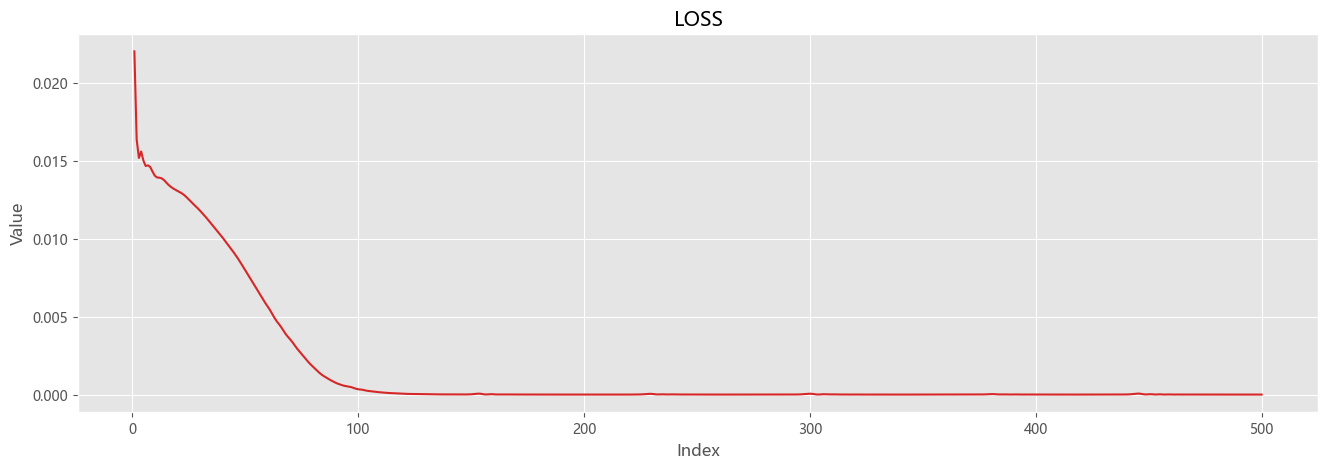

In [60]:
# plot_df(df, x=range(epoch_n), y= lr_list, title='LOSS')
plot_df(df, x=ep, y= losses, title='LOSS')

### 检验神经网络模型效果

In [61]:
torch.save(model, 'error_net.pkl')
model2 = torch.load('error_net.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [62]:
num = 12
foreca = result.forecast(num)
foreca[0]

array([70.31280789, 70.30721427, 70.3015807 , 70.29594713, 70.29031357,
       70.28468   , 70.27904643, 70.27341286, 70.26777929, 70.26214573,
       70.25651216, 70.25087859])

In [63]:
# plot_df(df, x=range(3), y= foreca[0], title='Forcast')

In [64]:
foreca_val = foreca[0]+result_add.seasonal[6:num+6]
# 加上周期值
top = []
bottom = []
for data in foreca[2]:
    top.append(data[1])
    bottom.append(data[0])
top = top + result_add.seasonal[6:num+6]
bottom = bottom + result_add.seasonal[6:num+6]

In [65]:
foreca_val[6]

70.25413730216134

In [66]:
MSE = 0
for i in range(num):
    MSE += (foreca_val[6+i] - df["内存负载"].loc[2046+i])**2
MSE

0.3149229456785877

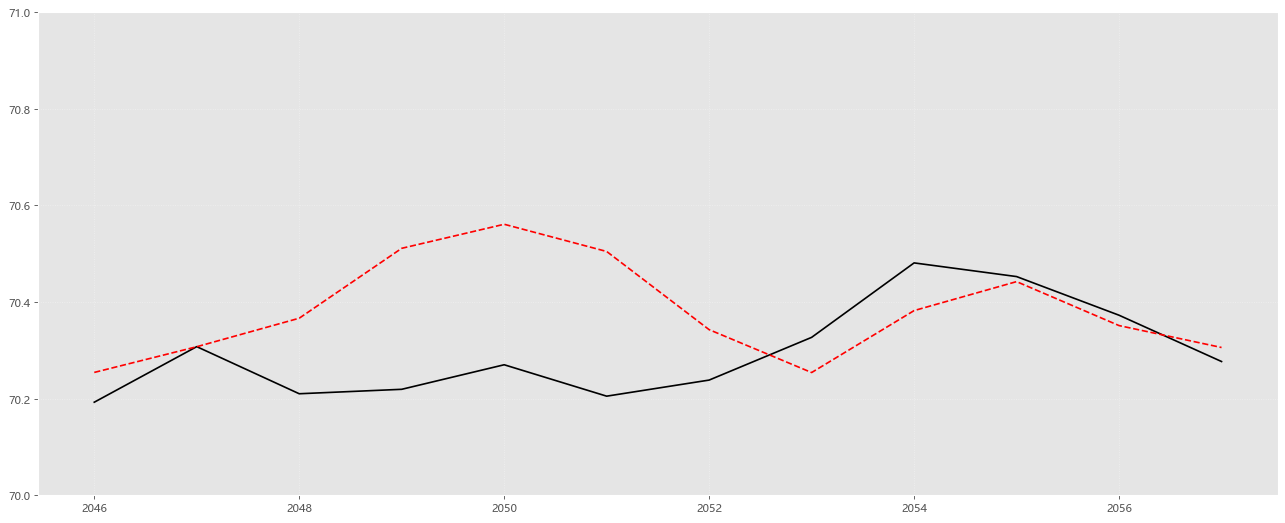

In [67]:
plt.figure(figsize=(20,8),dpi=80)
test_temp = df["内存负载"][len(train):len(train)+num]
# color可以百度颜色代码
plt.plot(test_temp.index,test_temp,label="truth",color="black")
plt.plot(test_temp.index,foreca_val,label="predict",color="red",linestyle="--")
# plt.fill_between(test_temp.index,top,bottom,color='blue',alpha=0.05)
#绘制网格
plt.grid(alpha=0.4,linestyle=':')
plt.ylim(70,71)
#展示
plt.show()

In [68]:
outputs = model2(test_X)
error_list = outputs.detach().numpy().tolist()
error_list[0][0]

[-0.09529320150613785,
 0.08803822100162506,
 -0.10686784237623215,
 -0.17468763887882233,
 0.04263858497142792,
 -0.13748033344745636,
 0.11576618254184723,
 0.08697432279586792,
 -0.07157216221094131,
 -0.19420583546161652,
 0.326970636844635,
 -0.276569128036499]

In [69]:
foreca_val.values

array([70.2541373 , 70.30733605, 70.36632623, 70.51098489, 70.56075444,
       70.50445392, 70.34262983, 70.25389432, 70.38210183, 70.44205984,
       70.35107697, 70.30571725])

In [70]:
prdict = foreca_val.values + error_list[0][0]
prdict

array([70.1588441 , 70.39537427, 70.25945839, 70.33629725, 70.60339303,
       70.36697359, 70.45839602, 70.34086864, 70.31052967, 70.247854  ,
       70.6780476 , 70.02914813])

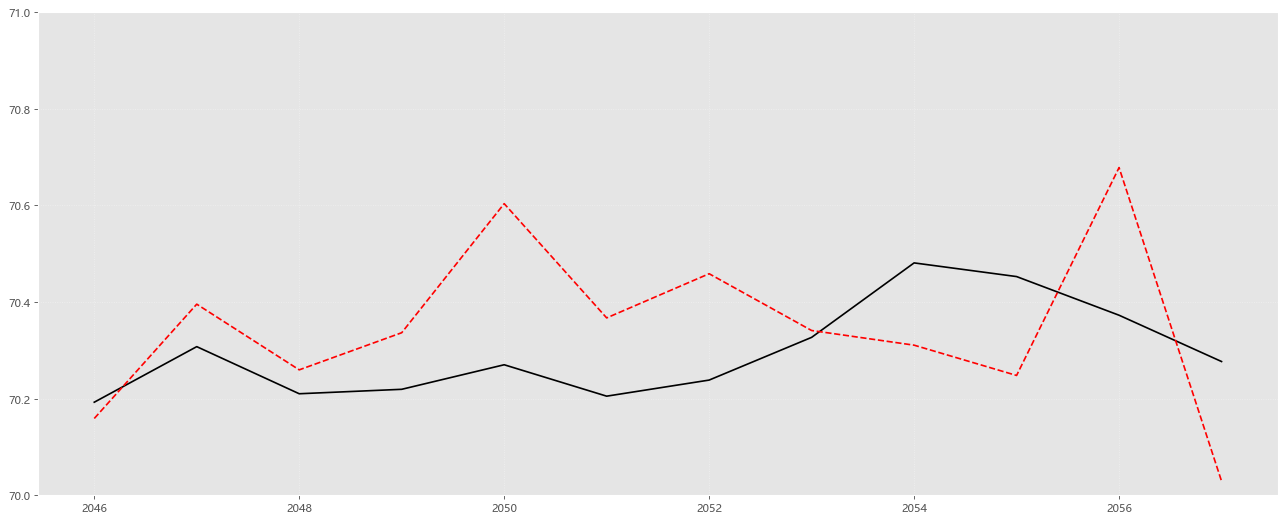

In [71]:
plt.figure(figsize=(20,8),dpi=80)
test_temp = df["内存负载"][len(train):len(train)+num]
plt.plot(test_temp.index,test_temp,label="truth",color="black")
plt.plot(test_temp.index,prdict,label="predict",color="red",linestyle="--")
plt.grid(alpha=0.4,linestyle=':')

plt.ylim(70,71)
#展示
plt.show()

In [72]:
MSE = 0
for i in range(num):
    MSE += (prdict[i] - df["内存负载"].loc[2046+i])**2
MSE

0.43655510310091716

### 差分

In [73]:
# # 差分法生成序列
# dif = []
# dif = train.diff(1)

### ADF检验

In [74]:
# timeSeries = dif[1:]
# adftest = ts.adfuller(timeSeries)
# adftest

### ACF和PACF观察

In [75]:
# plot_acf(timeSeries).show()

In [76]:
# plot_pacf(timeSeries).show()

### BIC和AIC定阶

In [77]:
# p_min = 0
# q_min = 0
# p_max = 5
# q_max = 6
# d_min = 0
# d_max = 1

In [78]:
# results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
#                            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
# results_bic

In [79]:
# num = 1
# for p,d,q in itertools.product(range(p_min,p_max+1),
#                                range(d_min,d_max+1),
#                                range(q_min,q_max+1)):
#     if p==0 and d==0 and q==0:
#         results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
#         continue
 
#     try:
#         model = sm.tsa.ARIMA(timeSeries, order=(p, d, q),
# #                                enforce_stationarity=False,
# #                                enforce_invertibility=False,
#                               )
#         results = model.fit()
#         num += 1
#         print(f"循环{num}次")
#         results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
#     except:
#         continue
# results_bic = results_bic[results_bic.columns].astype(float)
# fig, ax = plt.subplots(figsize=(10, 8))
# ax = sns.heatmap(results_bic,
#                  mask=results_bic.isnull(),
#                  ax=ax,
#                  annot=True,
#                  fmt='.2f',
#                  )
# ax.set_title('BIC')

### 验证模型

In [80]:
# from statsmodels.graphics.api import qqplot
# from statsmodels.stats.stattools import durbin_watson #DW检验
# #残差
# model = sm.tsa.ARIMA(timeSeries, order=(0, 1, 2))
# results = model.fit()
# resid = results.resid 
# #利用QQ图检验残差是否满足正态分布
# plt.figure(figsize=(12,8))
# qqplot(resid,line='q',fit=True)
# #利用D-W检验,检验残差的自相关性
# print('D-W检验值为{}'.format(durbin_watson(resid.values)))
# # 当D-W检验值接近于2时，不存在自相关性，说明模型较好。
# # https://wenku.baidu.com/view/57224dcfcf84b9d528ea7aba.html